Import libraries

In [21]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

Define functions needed 

In [22]:
# Function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [23]:
# Function to initialize particles with random centroids
def initialize_particles(num_particles, num_clusters, nd):
    particles = []
    for _ in range(num_particles):
        particle = np.random.rand(num_clusters, nd)
        particles.append(particle)
    return particles

In [24]:
# Function to initialize velocities for centroids in particles
def initialize_velocities(num_particles, num_clusters, num_dimensions):
    velocities = []
    for _ in range(num_particles):
        particle_velocities = []
        for _ in range(num_clusters):
            velocity = np.zeros(num_dimensions)
            particle_velocities.append(velocity)
        velocities.append(particle_velocities)
    return velocities

In [25]:
# Function to lable data vectors to the nearest cluster centroid
def assign_cluster_lable(data, particle):
    clusters_lables_particle = [[] for _ in data]
    for pointIndex,point in enumerate(data):
        distances = [euclidean_distance(point, centroid) for centroid in particle]
        nearest_centroid_index = np.argmin(distances)
        clusters_lables_particle[pointIndex] = nearest_centroid_index
        
    return clusters_lables_particle

In [26]:
# Fitness function based on quantization error
def calculate_fitness(data, centroids):
    total_error = 0
    for point in data:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        nearest_centroid_index = np.argmin(distances)
        nearest_centroid = centroids[nearest_centroid_index]
        quantization_error = euclidean_distance(point, nearest_centroid)
        total_error += quantization_error
    return len(data) / total_error  # Invert quantization error to convert to fitness value

In [27]:
#Initialize fitness of the particles
def initialize_fitness(data, particles):
  local_fitnesses = []
  for particle in enumerate(particles):
    local_fitnesses.append(calculate_fitness(data,particle))
  return local_fitnesses

In [28]:
# Update velocities
def update_particle_velocity(particle, velocity, w, c1, c2, global_best_particle, local_best_particle,no_of_clusters, nd):
    r1 = np.random.rand(no_of_clusters, nd)
    r2 = np.random.rand(no_of_clusters, nd)
    new_velocity = w * velocity + c1 * r1 * (local_best_particle - particle) + c2 * r2 * (global_best_particle - particle)
    #cliped_new_velocity = clip_velocity_with_max(new_velocity, v_max)
    return new_velocity.tolist()

In [29]:
# Update centroids
def update_particle_centroid(particle, velocity):
    new_centroid = particle + velocity
    return new_centroid

In [30]:
# Update local best particle position 
def update_local_best(particle,local_fitness,local_best_fitness,particle_index,local_best_particles):
  if local_fitness[particle_index] > local_best_fitness[particle_index]:
    local_best_particles[particle_index] = particle
    local_best_fitness[particle_index] = local_fitness[particle_index]
    
  return local_best_particles,local_best_fitness

In [31]:
# Update global best particle postion
def update_global_best_particle(particles,local_fitness):
  max_fitness_index = np.argmax(local_fitness)
  global_best_particle = particles[max_fitness_index]
  return global_best_particle, max_fitness_index

In [32]:
def pso_clustering(data, num_clusters, num_particles, max_iterations, w, c1, c2):
    nd = len(data[0])  # Dimension of input data vectors

    # Initialize particles centroids 
    particles_centroids = initialize_particles(num_particles, num_clusters, nd)
    
    # Initialize velocities 
    velocities = initialize_velocities(num_particles,num_clusters, nd)

    # Initialize local best particle
    local_best_particles = [particle.copy() for particle in particles_centroids]
    
    # Calculate fitness for particle particles
    local_fitnesses = initialize_fitness(data, particles_centroids)
    
    # Initialize local best particles
    local_best_fitness = list(local_fitnesses)
    
    # Initialize max fitness index
    max_fitness_index = np.argmax(local_fitnesses)
    
    # Initialize global best particles
    global_best_particle = particles_centroids[max_fitness_index]

    for iteration_no, _ in enumerate(range(max_iterations)):
        
        # Define cluster lable list
        clusters = []
        # Define cluster lable list
        clusters_lables = []
        for particle_index, particle in enumerate(particles_centroids):
           
            # Assign cluster labels to data
            clusters_lables.append(assign_cluster_lable(data,particle))
            
            # Calculate fitness of the particle
            local_fitnesses[particle_index] = calculate_fitness(data,particle)
            
            # Update velocities
            velocities[particle_index] = update_particle_velocity(np.array(particle), np.array(velocities[particle_index]), w, c1, c2, np.array(global_best_particle), np.array(local_best_particles[particle_index]),num_clusters, nd)
            
            # Update particle centroids
            particles_centroids[particle_index] = update_particle_centroid(particle, velocities[particle_index])
            
            # Update local best particle and local best fitness value
            local_best_particles, local_best_fitness = update_local_best(particle, local_fitnesses, local_best_fitness, particle_index,local_best_particles)
             
        # Update globle best particle and globle best fitness value  
        global_best_particle, max_fitness_index = update_global_best_particle(particles_centroids,local_fitnesses)
        
        if iteration_no%10 == 0:
            print("------------------------------------------------------------- " )
            # Print iteration number
            print("Iteration : " +str(iteration_no))
            # Print globle best fitness
            print("Max finess of the iteration : " + str(local_fitnesses[max_fitness_index]))
            
    
    # Print final globle best particle fitness
    print("------------------------------------------------------------- " )
            # Print iteration number
    print("Iteration : " +str(max_iterations))
            # Print globle best fitness
    print("Max finess of the iteration : " + str(local_fitnesses[max_fitness_index]))    
    return global_best_particle,clusters_lables[max_fitness_index]


Data preprocessing

In [33]:
# Read CSV file
iris = pd.read_csv("Iris.csv")

# Removing Unnecessary Columns
iris.drop(columns=['Id'], inplace=True)

# Encoding Categorical Variables ('Species')
label_encoder = LabelEncoder()
iris['Species'] = label_encoder.fit_transform(iris['Species'])

# Scaling Features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(iris.drop(columns=['Species']))
iris_scaled = pd.DataFrame(scaled_features, columns=iris.columns[:-1])  # Exclude 'Species' from scaling

print(iris_scaled.head())

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0       0.222222      0.625000       0.067797      0.041667
1       0.166667      0.416667       0.067797      0.041667
2       0.111111      0.500000       0.050847      0.041667
3       0.083333      0.458333       0.084746      0.041667
4       0.194444      0.666667       0.067797      0.041667


Run pso_clustering with suitable parameter values

In [34]:
# Extracting the values of the DataFrame as a NumPy array
data = iris_scaled.values 

# Call the pso_clustering function with scaled data
num_clusters = 3  # Define the number of clusters
num_particles = 10  # Define the number of particles
max_iterations = 100 # Define the maximum number of iterations
w = 0.5  # Define the inertia weight
c1 = 1.49 # Define the cognitive parameter
c2 = 1.49  # Define the social parameter

global_best_particle, predicted_class_lables = pso_clustering(data, num_clusters, num_particles, max_iterations, w, c1, c2)

------------------------------------------------------------- 
Iteration : 0
Max finess of the iteration : 2.458470528108453


------------------------------------------------------------- 
Iteration : 10
Max finess of the iteration : 2.1975815810757684
------------------------------------------------------------- 
Iteration : 20
Max finess of the iteration : 3.01176715119409
------------------------------------------------------------- 
Iteration : 30
Max finess of the iteration : 3.7623264210487894
------------------------------------------------------------- 
Iteration : 40
Max finess of the iteration : 4.0385435478766585
------------------------------------------------------------- 
Iteration : 50
Max finess of the iteration : 4.051729033276446
------------------------------------------------------------- 
Iteration : 60
Max finess of the iteration : 4.77999314340731
------------------------------------------------------------- 
Iteration : 70
Max finess of the iteration : 4.834600894855689
------------------------------------------------------------- 
Iteration : 80
Max finess of the iteration : 4.8277175

Mapping clusters to ground truth 

In [35]:
# Map predicted clusters to ground truth classes
predicted_class_lables_np = np.array(predicted_class_lables)
mapping = {}
for cluster in range(3):
    # Get the majority class in terms of numerical values
    majority_class_numeric = iris['Species'].iloc[predicted_class_lables_np == cluster].mode()[0] #if error occures here run all the code again(this error occured due poor clustering.when we get only 2 clusters this error occur)
    
    mapping[cluster] = majority_class_numeric
    
    
# Define class_names list relavant to iris data set
class_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

# Create a dictionary to map numeric labels to class names
numeric_to_class = {0: class_names[mapping[0]],
                    1: class_names[mapping[1]],
                    2: class_names[mapping[2]]}

print(numeric_to_class)

{0: 'Iris-virginica', 1: 'Iris-versicolor', 2: 'Iris-setosa'}


Visualising the predicted clusters

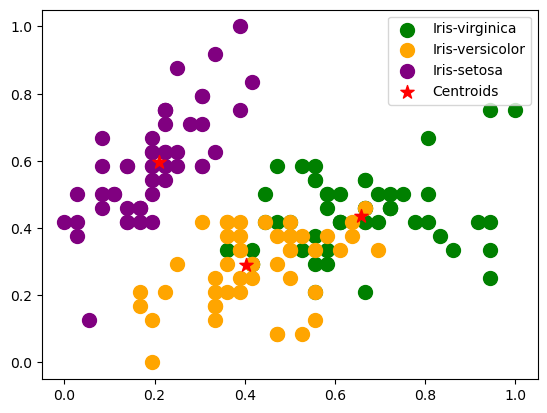

In [36]:
# Visualising the clusters 
cols = iris.columns 
class_colors = {'Iris-setosa': 'purple', 
                'Iris-versicolor': 'orange', 
                'Iris-virginica': 'green'}
for numeric_label, class_name in numeric_to_class.items():
    color = class_colors[class_name]
    plt.scatter(iris_scaled.loc[predicted_class_lables_np == numeric_label, cols[0]], 
                iris_scaled.loc[predicted_class_lables_np == numeric_label, cols[1]], 
                s=100, c=color, 
                label=class_name) 

# Plotting the centroids of the clusters 
plt.scatter(global_best_particle[:, 0], 
			global_best_particle[:, 1], 
			s=100, c='red', 
			label='Centroids',
   		marker='*') 

plt.legend() 

Implement evaluation metrics to assess the quality of clustering results obtain by PSO algorithm

In [37]:
# Calculate the quantization error
def calculate_quantization_error(data, centroids):
    total_error = 0
    for point in data:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        nearest_centroid_index = np.argmin(distances)
        nearest_centroid = centroids[nearest_centroid_index]
        quantization_error = euclidean_distance(point, nearest_centroid)
        total_error += quantization_error
    return total_error / len(data) 

In [38]:

# Compute Quantization_error
quantization_error = calculate_quantization_error(data, global_best_particle)

# Compute Silhouette Score
silhouette_avg = silhouette_score(iris_scaled, predicted_class_lables_np)

# Compute Davies-Bouldin Index
davies_bouldin_idx = davies_bouldin_score(iris_scaled, predicted_class_lables_np)

# Compute Calinski-Harabasz Index
calinski_harabasz_idx = calinski_harabasz_score(iris_scaled, predicted_class_lables_np)

print(f"Quantization Score: {quantization_error}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_idx}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_idx}")

Quantization Score: 0.19659444791617278
Silhouette Score: 0.4822748343598164
Davies-Bouldin Index: 0.7880633307836606
Calinski-Harabasz Index: 347.56448581927094


Visualize how may data points clustersd correctly

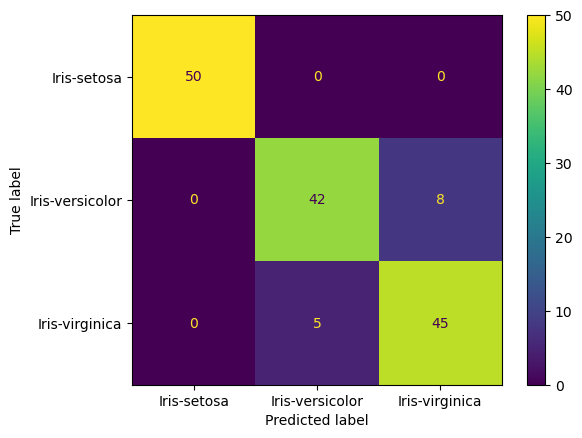

In [39]:
# Ground truth vector
y_true = np.array(iris['Species'].tolist())

#Predicted cluster lable vector
y_pred_mapped = [mapping[cluster] for cluster in predicted_class_lables_np]

cnf_matrix = confusion_matrix(y_true , y_pred_mapped)
cm_display = ConfusionMatrixDisplay.from_predictions(y_true,y_pred_mapped , display_labels = class_names)


Calculating Accuracy from Confusion Matrix

In [40]:
# Calculate clustering accuracy
accuracy = np.trace(cnf_matrix) / np.sum(cnf_matrix)
print("Clustering Accuracy: {:.2f}%".format(accuracy * 100))

Clustering Accuracy: 91.33%
